#TO DO

- ~~**change batch_size in cell [23]**~~
- ~~**change epochs in cell [23]**~~
- ~~**change importing image in cell [5]**~~
- ~~import all train images and train~~
- ~~import test images and fit~~
- ~~export csv with test image results~~
- data augmentation
- train test split
- try dropouts
- try reducing the complexity
- try AvgPooling
- try managing memory with `del`

```# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
```

For the data augmentation, i choosed to :

- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally. Once our model is ready, we fit the training dataset
```
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
```
```
datagen.fit(x_train)
```

In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
from numpy.linalg import inv, norm
from IPython.display import display 
import pandas


drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/Xrays/')
print('\n',os.getcwd())
print("\n")
print(os.listdir())

save_dir = os.path.join(os.getcwd(),'saved_models')

##Imports for the Learning and the plotting
import keras
import tensorflow as tf

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, \
                                    AveragePooling2D, Input, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


##Import for preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 /content/drive/MyDrive/Xrays


['labels_train.csv', 'sample_submission.csv', 'labels_train.xlsx', 'train_images', 'saved_models', 'model.png', 'test_images', 'submission_file_herck.csv']


In [ ]:
from PIL import Image

def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

width = height = 270

In [ ]:
data= pandas.read_csv('/content/drive/MyDrive/Xrays/labels_train.csv', header=None, usecols=[0,1], names=['file_name', 'class_id'])
#print(labels[1:])
labels = data['class_id'].values
labels = labels[1:]
img_name = data['file_name'].values
img_name = img_name[1:]

#data_labels = np.array(data[1:])
#print(data_labels.shape)   

labels = np.array(labels)
print(labels.shape)   
print(labels)

(4672,)
['1' '2' '2' ... '1' '1' '1']


In [ ]:
train_imgs = []
for i in range(img_name.size):
  img = Image.open('/content/drive/MyDrive/Xrays/train_images/{train_image}'.format(train_image=img_name[i]))
  train_imgs.append(img)

print("Loaded Training data")

Loaded Training data


In [ ]:
for i in range(img_name.size):
  train_imgs[i]= resize(train_imgs[i], width, height)

In [ ]:
for i in range(img_name.size):
  train_imgs[i]= np.asarray(train_imgs[i])

In [ ]:
train_imgs = np.array(train_imgs, dtype="float32")/255.0

print(train_imgs.shape)

(4672, 270, 270, 3)


In [ ]:
depth = 8

#x_train = train_imgs[:2803]
#y_train = labels[:2803]
#x_test = train_imgs[2803:]
#y_test = labels[2803:]
num_classes = 3

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_imgs,labels, test_size=0.15)

input_shape = x_train.shape[1:]

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

t_train = keras.utils.to_categorical(y_train, num_classes)
t_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train (labels) shape:', y_train.shape)
print('t_train (one-hot rep) shape:', t_train.shape)

x_train shape: (3737, 270, 270, 3)
3737 train samples
935 test samples
y_train (labels) shape: (3737,)
t_train (one-hot rep) shape: (3737, 3)


In [ ]:
print(y_test)
print(t_test)
print(y_train)
print(t_train)
print(input_shape)

['1' '2' '0' ... '1' '1' '1']
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
['1' '2' '2' ... '1' '1' '1']
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(256, 256, 3)


In [ ]:
#Idk which one works 
train_imgs = []
train_imgs = None
del train_imgs
labels = []
labels = None
del labels

y_test = []
y_test = None
del y_test

y_train = []
y_train = None
del y_train

#Trying to release memory

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=3):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=2, ### originally: 1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    print('Model parameters: {:d}'.format(model.count_params()))
    return model

In [ ]:
def lr_schedule(epoch):
  lr = 1e-3
  if (epoch>180) :
      lr *= 0.5e-3
  elif epoch > 160:
      lr *= 1e-3
  elif epoch > 120:
      lr *= 1e-2
  elif epoch > 80:
      lr *= 1e-1
  return lr

In [ ]:
class MyCallback(keras.callbacks.Callback):
    tstart = None
    def on_train_begin(self, logs={}):
        return
    
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        self.tstart = time.time()
        print('epoch:{:03d}'.format(epoch+1), end=', ')
        return
    
    def on_epoch_end(self, epoch, logs={}):
        print('loss:{:8.6f}, acc:{:8.6f},  val_loss:{:8.6f}, val_acc:{:8.6f},  val_acc-acc = {:5.2f}%,  lr:{:0.6f}  [{:0.2f} sec]'.format(
                logs.get('loss'), logs.get('acc'),
                logs.get('val_loss'), logs.get('val_acc'),
                100*(logs.get('val_acc')-logs.get('acc')),
                K.eval(self.model.optimizer.lr),
                time.time()-self.tstart))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
model = resnet_v1(input_shape=input_shape, depth=depth)
    
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200

# Prepare model model saving directory.
model_name = 'resnet8-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear                                                  ## dew it
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)              ##dew it
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, t_train, batch_size=batch_size), 
                    validation_data=(x_test, t_test), epochs=epochs, verbose=0, 
                    workers=4, steps_per_epoch = int(x_train.shape[0]/batch_size), 
                    callbacks=[lr_reducer, lr_scheduler, MyCallback(), checkpoint])

# Score trained model.
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

epoch:001, loss:1.243607, acc:0.616464,  val_loss:0.766715, val_acc:0.686631,  val_acc-acc =  7.02%,  lr:0.001000  [53.65 sec]

Epoch 00001: val_acc improved from -inf to 0.68663, saving model to /content/drive/MyDrive/Xrays/saved_models/resnet44-e0001-loss1.244-acc0.616-valloss0.767-valacc0.687.h5
epoch:002, loss:0.770316, acc:0.700405,  val_loss:0.747147, val_acc:0.658824,  val_acc-acc = -4.16%,  lr:0.001000  [47.97 sec]

Epoch 00002: val_acc did not improve from 0.68663
epoch:003, loss:0.710343, acc:0.725506,  val_loss:0.731731, val_acc:0.698396,  val_acc-acc = -2.71%,  lr:0.001000  [47.91 sec]

Epoch 00003: val_acc improved from 0.68663 to 0.69840, saving model to /content/drive/MyDrive/Xrays/saved_models/resnet44-e0003-loss0.710-acc0.726-valloss0.732-valacc0.698.h5
epoch:004, loss:0.690686, acc:0.730364,  val_loss:0.570896, val_acc:0.792513,  val_acc-acc =  6.21%,  lr:0.001000  [48.09 sec]

Epoch 00004: val_acc improved from 0.69840 to 0.79251, saving model to /content/drive/MyDri

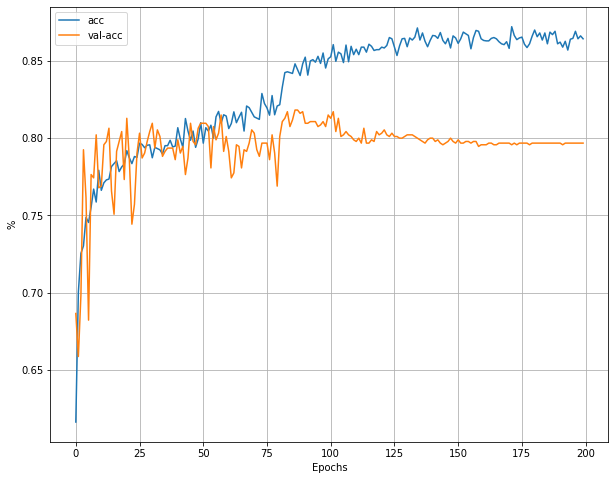

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
test_imgs_paths = os.listdir('/content/drive/MyDrive/Xrays/test_images/')
test_imgs = []
for path in test_imgs_paths:
  img = Image.open('/content/drive/MyDrive/Xrays/test_images/{test_image}'.format(test_image=path))
  test_imgs.append(img)

print("Loaded Test data")

Loaded Test data


In [ ]:
for i in range(len(test_imgs_paths)):
  test_imgs[i]= resize(test_imgs[i], width, height)
  test_imgs[i]= np.asarray(test_imgs[i])

test_imgs = np.array(test_imgs, dtype="float32")/255.0

print(test_imgs.shape)

(1168, 270, 270, 3)


In [ ]:
def getMaxIndex(list):
  maxim= max(list)
  for i in range(len(list)):
    if maxim == list[i]:
      return i

In [ ]:
predictions = model.predict(test_imgs)

In [ ]:
import csv

with open('submission_resnet8_270p_batch32(2).csv', mode='w') as submission_file:
    submission_file = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    submission_file.writerow(['file_name', 'class_id'])
    j=0
    for i  in predictions:
      #print("image : {img} \t\tclass : {i}".format(img=test_imgs_paths[j], i=getMaxIndex(i)))
      submission_file.writerow(['{img}'.format(img=test_imgs_paths[j]), '{i}'.format(i=getMaxIndex(i))])
      j+=1